In [ ]:
# default_exp core

# Glycowork

> Glycans are a fundamental biological sequence, similar to DNA, RNA, or proteins. Glycans are complex carbohydrates that can form branched structures comprising monosaccharides and linkages as constituents. Despite being conspicuously absent from most research, glycans are ubiquitous in biology. They decorate most proteins and lipids and direct the stability and functions of biomolecules, cells, and organisms. This also makes glycans relevant to every human disease.

> The analysis of glycans is made difficult by their nonlinearity and their astounding diversity, given the large number of monosaccharides and types of linkages. Glycowork is a Python package designed to process and analyze glycan sequences, with a special emphasis on glycan-focused machine learning. Next to various functions to work with glycans, Glycowork also contains glycan data that can be used for glycan alignments, model pre-training, motif comparisons, etc.

> Where possible, glycowork uses the IUPAC-condensed nomenclature for glycan. An example for this would be `Man(a1-3)[Man(a1-6)]Man(b1-4)GlcNAc(b1-4)GlcNAc`, in which parentheses enclose the linkage description and brackets indicate branches. Ideally, the longest branch should constitute the main chain and side branches should be ordered ascendingly based on the last linkage of the branch (yet all functions in glycowork can deal with violations to these guidelines). Where possible/known, monosaccharide modifications are indicated by the ring position to which they are attached (e.g., Glc6Me), while the type of connection is given if the exact position is unknown (e.g., GlcOMe). Linkage uncertainty is usually expressed with a 'bond' placeholder.

In [ ]:
#hide
from nbdev.showdoc import *
import pandas as pd
from glycowork.glycan_data.loader import df_species, glycan_emb
from glycowork.motif.analysis import plot_embeddings, make_heatmap
from glycowork.motif.processing import presence_to_matrix

All modules in glycowork, **except** for `ml`, can be run on any machine. For most parts of `ml`, however, a GPU is needed to load and run torch_geometric.

If you want to run `glycowork.ml` in a Jupyter Notebook (in the cloud or wherever you have a GPU), just run this prior to importing glycowork:
```
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-geometric
```

Okay, how about an example! <br>
Let's say you're interested in glycans of the plant order Fabales. that includes the legumes. Luckily, we've got you covered and `df_species` has ~500 glycan sequences that stem from Fabales. So the first step is easy: import `df_species` from `glycowork.glycan_data.loader` and filter for Fabales glycans.

In [ ]:
df_fabales = df_species[df_species.order == 'Fabales'].reset_index(drop = True)
df_fabales

,target,species,genus,family,order,class,phylum,kingdom,domain,ref
0,Man(a1-3)[Man(a1-6)][Xyl(b1-2)]Man(b1-4)GlcNAc...,Arachis_hypogaea,Arachis,Fabaceae,Fabales,Dicotyledons,Angiosperms,Plantae,Eukarya,NaN
1,Fuc(a1-4)[Gal(b1-3)]GlcNAc(b1-2)Man(a1-3)[Fuc(...,Arachis_hypogaea,Arachis,Fabaceae,Fabales,Dicotyledons,Angiosperms,Plantae,Eukarya,NaN
2,Man(a1-3)Man(a1-6)[Man(a1-3)][Xyl(b1-2)]Man(b1...,Arachis_hypogaea,Arachis,Fabaceae,Fabales,Dicotyledons,Angiosperms,Plantae,Eukarya,NaN
3,Man(a1-3)[Man(a1-6)]Man(a1-6)[Man(a1-2)Man(a1-...,Arachis_hypogaea,Arachis,Fabaceae,Fabales,Dicotyledons,Angiosperms,Plantae,Eukarya,NaN
4,Man(a1-3)[Man(a1-6)]Man(a1-6)[Man(a1-3)]Man(b1...,Arachis_hypogaea,Arachis,Fabaceae,Fabales,Dicotyledons,Angiosperms,Plantae,Eukarya,NaN
...,...,...,...,...,...,...,...,...,...,...
483,Gal(a1-6)Gal(a1-6)Glc(a1-2)Fruf,Vigna_unguiculata,Vigna,Fabaceae,Fabales,Dicotyledons,Angiosperms,Plantae,Eukarya,NaN
484,Gal(a1-6)Glc(a1-2)Fruf,Vigna_unguiculata,Vigna,Fabaceae,Fabales,Dicotyledons,Angiosperms,Plantae,Eukarya,NaN
485,Rha(a1-2)Xyl(b1-2)GlcA,Wisteria_brachybotrys,Wisteria,Fabaceae,Fabales,Dicotyledons,Angiosperms,Plantae,Eukarya,NaN
486,Rha(a1-2)Gal(b1-2)GlcA,Wisteria_brachybotrys,Wisteria,Fabaceae,Fabales,Dicotyledons,Angiosperms,Plantae,Eukarya,NaN


Now, if you're not a plant glycobiologist, that may seem a bit overwhelming to you. But fear not, we can just **plot** glycans. How? Easy: Glycan representations! <br>

Representations or embeddings are really just a bunch of numbers learned by a machine learning model that express similarity. Meaning that if two glycans are similar (in sequence/properties/etc.), the difference between their representations should be small. Or, in other words, they should cluster in a plot. <br>

Now, you might not be in possession of a GPU and/or the wherewithal to train a glycan-focused deep learning model. That's why `glycowork` has both trained models and **already calculated** glycan representations waiting for you! And the best thing: you don't even need to worry about them. You just pass glycan sequences to our functions and `glycowork` will handle glycan representations behind the scenes. <br>

So, for our Fabales example, we pass our glycan sequences to `plot_embeddings` (from `glycowork.motif.analysis`), which will retrieve their learned representations, transform them into two dimensions via t-distributed stochastic neighbor embedding (t-SNE), and plot them! If you want, it can even color the resulting scatterplots by a label, for instance the taxonomic family within Fabales.

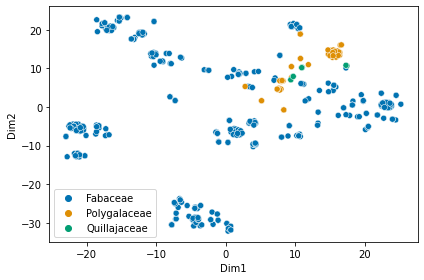

In [ ]:
plot_embeddings(df_fabales.target.values.tolist(), label_list = df_fabales.family.values.tolist())

Hmm, interesting. We definitely see clear glycan clusters (remember, every point is one glycan sequence). What's even cooler is that the families Polygalaceae and Quillajaceae cluster in a narrow region of the whole plot. I wonder what differentiates their glycans from Fabaceae? <br>

If you're also curious, proceed to the next function. First, we need to convert our data into a count table, with counts of every glycan in every family of Fabales. For this, you can use `presence_to_matrix` from the `glycowork.motif.processing` module, which was designed to work with tables such as `df_species`. Changing `label_col_name` to 'genus' will for instance generate a count table for all genera in Fabales.

In [ ]:
df_map = presence_to_matrix(df_fabales, label_col_name = 'family')
df_map

,Apif(a1-2)Xyl(b1-2)[GlcOAc(b1-4)]Glc,Ara(a1-2)Ara(a1-6)GlcNAc,Ara(a1-2)Glc(b1-2)Ara,Ara(a1-2)[Glc(b1-6)]Glc,Araf(a1-3)Gal(b1-6)Gal,D-Apif(b1-3)Xyl(b1-2)[GlcOAc(b1-4)]Glc,D-Apif(b1-3)Xyl(b1-4)Rha(a1-2)Ara,D-Apif(b1-3)Xyl(b1-4)Rha(a1-2)D-Fuc,D-Apif(b1-3)Xyl(b1-4)[Glc(b1-3)]Rha(a1-2)D-Fuc,D-ApifOMe(b1-3)XylOMe(b1-4)RhaOMe(a1-2)D-FucOMe,...,[Xyl(a1-6)]Glc(b1-4)[Gal(b1-2)Xyl(a1-6)]Glc(b1-4)[Gal(b1-2)Xyl(a1-6)]Glc(b1-4)Glc(b1-4)[Xyl(a1-6)]Glc(b1-4)[Xyl(a1-6)]Glc(b1-4)[Xyl(a1-6)]Glc(b1-4)Glc(b1-4)[Xyl(a1-6)]Glc(b1-4)[Gal(b1-2)Xyl(a1-6)]Glc(b1-4)[Xyl(a1-6)]Glc(b1-4)Glc(b1-4)[Xyl(a1-6)]Glc(b1-4)[Xyl(a1-6)]Glc(b1-4)[Xyl(a1-6)]Glc(b1-4)Glc(b1-4)[Xyl(a1-6)]Glc(b1-4)[Xyl(a1-6)]Glc(b1-4)[Gal(b1-2)Xyl(a1-6)]Glc(b1-4)Glc(b1-4)Glc,[Xyl(a1-6)]Glc(b1-4)[Gal(b1-2)Xyl(a1-6)]Glc(b1-4)[Xyl(a1-6)]Glc(b1-4)Glc(b1-4)[Gal(b1-5)Araf(a1-5)Araf(a1-6)]Glc(b1-4)[Gal(b1-2)Xyl(a1-6)]Glc(b1-4)Glc(b1-4)Glc,[Xyl(a1-6)]Glc(b1-4)[Gal(b1-2)Xyl(a1-6)]Glc(b1-4)[Xyl(a1-6)]Glc(b1-4)Glc(b1-4)[Gal(b1-5)Araf(a1-6)]Glc(b1-4)[Xyl(a1-6)]Glc(b1-4)[Xyl(a1-6)]Glc(b1-4)Glc(b1-4)Glc,[Xyl(a1-6)]Glc(b1-4)[Xyl(a1-6)]Glc(b1-4)[Fuc(a1-2)Gal(b1-2)Xyl(a1-6)]Glc(b1-4)Glc(b1-4)[Xyl(a1-6)]Glc(b1-4)[Xyl(a1-6)]Glc(b1-4)[Xyl(a1-6)]Glc(b1-4)Glc(b1-4)Glc,[Xyl(a1-6)]Glc(b1-4)[Xyl(a1-6)]Glc(b1-4)[Gal(b1-2)Xyl(a1-6)]Glc(b1-4)Glc(b1-4)[Gal(b1-5)Araf(a1-5)Araf(a1-6)]Glc(b1-4)[Gal(b1-2)Xyl(a1-6)]Glc(b1-4)Glc(b1-4)Glc,[Xyl(a1-6)]Glc(b1-4)[Xyl(a1-6)]Glc(b1-4)[Gal(b1-2)Xyl(a1-6)]Glc(b1-4)Glc(b1-4)[Gal(b1-5)Araf(a1-6)]Glc(b1-4)[Xyl(a1-6)]Glc(b1-4)[Xyl(a1-6)]Glc(b1-4)Glc(b1-4)Glc,[Xyl(a1-6)]Glc(b1-4)[Xyl(a1-6)]Glc(b1-4)[Xyl(a1-6)]Glc(b1-4)Glc(b1-4)[Gal(b1-5)Araf(a1-5)Araf(a1-6)]Glc(b1-4)[Gal(b1-2)Xyl(a1-6)]Glc(b1-4)Glc(b1-4)Glc,[Xyl(a1-6)]Glc(b1-4)[Xyl(a1-6)]Glc(b1-4)[Xyl(a1-6)]Glc(b1-4)Glc(b1-4)[Gal(b1-5)Araf(a1-6)]Glc(b1-4)[Gal(b1-2)Xyl(a1-6)]Glc(b1-4)[Xyl(a1-6)]Glc(b1-4)Glc(b1-4)Glc,[Xyl(a1-6)]Glc(b1-4)[Xyl(a1-6)]Glc(b1-4)[Xyl(a1-6)]Glc(b1-4)Glc(b1-4)[Gal(b1-5)Araf(a1-6)]Glc(b1-4)[Xyl(a1-6)]Glc(b1-4)[Gal(b1-2)Xyl(a1-6)]Glc(b1-4)Glc(b1-4)Glc,[Xyl(a1-6)]Glc(b1-4)[Xyl(a1-6)]Glc(b1-4)[Xyl(a1-6)]Glc(b1-4)Glc(b1-4)[Gal(b1-5)Araf(a1-6)]Glc(b1-4)[Xyl(a1-6)]Glc(b1-4)[Xyl(a1-6)]Glc(b1-4)Glc(b1-4)Glc
Fabaceae,1,3,1,1,1,1,1,0,0,0,...,1,1,1,1,1,1,1,1,1,1
Polygalaceae,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Quillajaceae,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


Okay, we're ready for some heatmaps! In `glycowork.motif.analysis`, we have a function titled `make_heatmap`, which...makes heatmaps.<br>

Specifically, it will generate clustermaps, that are aiming to cluster samples based on their glycan profile. Calling `make_heatmap` with `df_map` without any other arguments will try to cluster the samples based on their full glycan sequences. But we also have the `motif` mode, which extracts motifs from these glycans and clusters samples based on those. Here, I used the `known` (curated glycan motifs) and the `exhaustive` (all observed monosaccharides and disaccharides) options. Check out the documentation for more options! <br>

We can immediately see that we have a lot more *N*-linked glycans in Fabaceae, for instance based on the prominence of Trimannosylcore and Fuc(a1-3)GlcNAc. Glycans from Polygalaceae in `df_species` seem to mainly contain small molecule- and lipid-linked glycans, which of course are quite different from *N*-linked glycans.

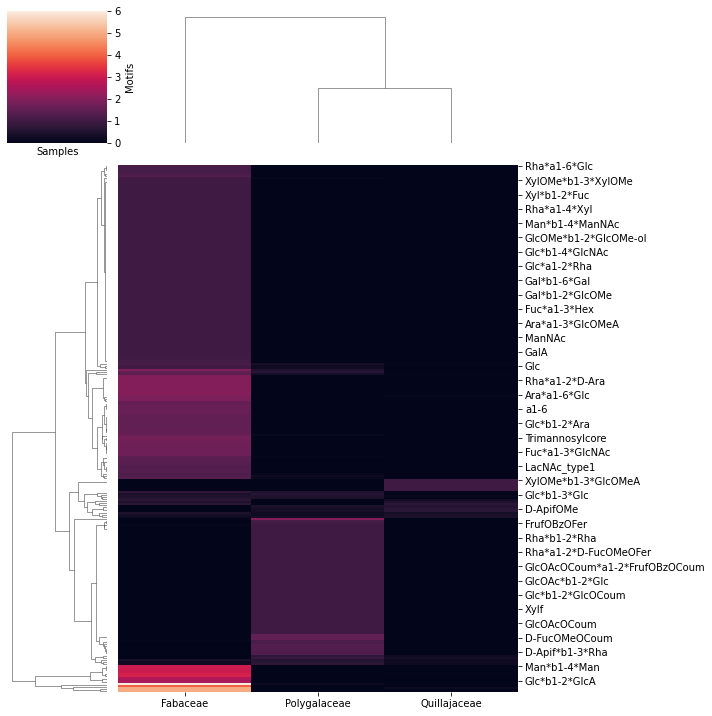

In [ ]:
make_heatmap(df_map, mode = 'motif', feature_set = ['known', 'exhaustive'])

And that's just a super-brief glimpse at the really cool functions contained in `glycowork`! This documentation describes all functions and what they're good for. Be sure to check out more, suggest improvements/fixes, and maybe even contribute something yourself. We are looking forward to your discoveries!

In [ ]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 00_core.ipynb.
Converted 01_alignment.ipynb.
Converted 02_glycan_data.ipynb.
Converted 03_ml.ipynb.
Converted 04_motif.ipynb.
Converted index.ipynb.
